In [11]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from copia import chao1

In [12]:
plt.style.use('science')

# Functions

In [13]:
def chao_wor(x, q, conf=0.95):
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    # Convert the int64 to longs to ensure the numbers
    # don't get too big in the variance calculation
    f1 = (x == 1).sum().item() # number of singletons
    f2 = (x == 2).sum().item() # number of doubletons
    w = n / (n - 1)
    r = q / (1 - q)
    f0 = (f1 ** 2) / (2 * w * f2 + r * f1)

    # compute sd
    t1 = ((2 * w * f2 * (f0**2) + (f1**2) * f0) ** 2) / (f1 ** 5)
    t2 = (4 * (w**2) * f2) * ((f0 / f1)**4)
    var = f0 + t1 + t2
        
    z = abs(stats.norm.ppf((1 - conf) / 2))
    K = np.exp(z * np.sqrt(np.log(1 + var / f0 ** 2)))
    lci, uci = t + f0 / K, t + f0 * K
    return {
        "q": q,
        "f1": f1,
        "f2": f2,
        "f0": f0,
        "V_obs": t,
        "V_est": math.ceil(t + f0), 
        "var": var,
        "sd": np.sqrt(var),
        "lci": lci,
        "uci": uci,
        "Chao1": chao1(x)
    }

# Loading Data

In [14]:
df = pd.read_csv('../data/raw/vocapture.csv')
df.head()

,vocop_id,disambiguated_person,person_cluster_id,date_begin_contract,outward_voyage_id
0,104944,1.0,415682.0,1700-05-05,92895
1,104945,1.0,406243.0,1700-05-05,92895
2,104946,1.0,1.0,1700-05-05,92895
3,104947,1.0,77235.0,1700-05-05,92895
4,104948,1.0,65732.0,1700-05-05,92895


__vocop_id__: the unique id for each contract \
__disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). \
__person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person \
__date_begin_contract__: start date of contract \
__outward_voyage_id__: unique id of outward voyage. 

In [15]:
print(f'total number of contracts: {df.shape[0]}')

total number of contracts: 774200


In [16]:
nans = df['date_begin_contract'].isnull().sum()
print(f'number of nans in date field: {nans}')
df = df.dropna(subset=['date_begin_contract'])

number of nans in date field: 257


In [17]:
#only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
print(f'number of disambiguated records: {len(records)}')

number of disambiguated records: 546973


In [18]:
# construct year variable
df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df = df.sort_values(by='year')
df["year"].unique()

array([1633, 1635, 1636, 1637, 1638, 1640, 1641, 1643, 1644, 1645, 1646,
       1647, 1648, 1649, 1661, 1662, 1668, 1671, 1672, 1674, 1675, 1676,
       1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687,
       1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698,
       1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709,
       1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720,
       1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731,
       1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742,
       1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753,
       1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764,
       1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775,
       1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786,
       1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794])

In [19]:
df_disambiguated = df.loc[df['disambiguated_person'] == 1]
df_unique_persons = df.loc[df['disambiguated_person'] == 1].drop_duplicates(subset=['person_cluster_id'])

## plot time series




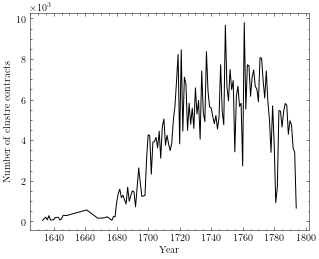

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

df_disambiguated.groupby('year')['date_begin_contract'].count().plot(ax=ax, color="k", label=None) # disambiguated
ax.set(xlabel='Year', ylabel='Number of clustre contracts')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.savefig('../figures/total_contracts.png', dpi=300)

## Calculating number of sailors on a ship

In [22]:
# remove outward_voyage_id 0
sailors_df = df[df['outward_voyage_id'] != 0]

In [24]:
# For the calculation of the median and mean, we outward voyages to which no contracts are linked. 

mean_sailors = sailors_df.groupby(['outward_voyage_id'])['vocop_id'].count().mean()
median_sailors = sailors_df.groupby(['outward_voyage_id'])['vocop_id'].count().median()
print(f'mean sailors on a ship: {mean_sailors}')
print(f'median sailors on a ship: {median_sailors}')
n_records = 4_352

mean sailors on a ship: 244.59721342621913
median sailors on a ship: 247.0


In [74]:
# I used person_cluster_id before, this should be vocop_id, we want to use all records
# not only the disambiguated ones


In [25]:
counts = np.array(list(collections.Counter(records).values()))
N_obs, V_obs = counts.sum(), counts.shape[0]

#N, V = len(records), len(np.unique(records))
print(f"The archive consists of N={N_obs} records and V_obs={V_obs} unique sailors.")

The archive consists of N=546973 records and V_obs=460274 unique sailors.


### Using Mean Sailors

In [34]:
N_est = int(mean_sailors * n_records)
print(N_est)

1064487


In [35]:
q = N_obs / N_est
print(q)

0.5138371816659104


In [36]:
estimates = chao_wor(counts, q)
estimates

{'q': 0.5138371816659104,
 'f1': 401179,
 'f2': 42889,
 'f0': 315705.2121473892,
 'V_obs': 460274,
 'V_est': 775980,
 'var': 720580.4720172862,
 'sd': 848.8701149276527,
 'lci': 774319.8365583214,
 'uci': 777647.3556519173,
 'Chao1': 2336562.7429766366}

In [37]:
estimates['V_obs'] /estimates['V_est']

0.59315188535787

### Using Median

In [38]:
N_est = int(median_sailors * n_records)
print(N_est)

1074944


In [39]:
q = N_obs / N_est
print(q)

0.5088385999642772


In [40]:
estimates = chao_wor(counts, q)
estimates

{'q': 0.5088385999642772,
 'f1': 401179,
 'f2': 42889,
 'f0': 320993.07334599714,
 'V_obs': 460274,
 'V_est': 781268,
 'var': 743535.5172261045,
 'sd': 862.2850556666888,
 'lci': 779581.470028203,
 'uci': 782961.5748538171,
 'Chao1': 2336562.7429766366}

In [41]:
estimates['V_obs'] / estimates['V_est'] 

0.5891371462801497

Note that Chao1 gives an unrealistic lowerbound of more than 2 million, which by far exceeds the know upper limt of N_est. 

## per 25 years

In [47]:
bins = list(range(1633, 1795, 25)) + [1795]
date_ranges = [(bins[i-1], bins[i]) for i in range(1, len(bins))]
date_ranges

[(1633, 1658),
 (1658, 1683),
 (1683, 1708),
 (1708, 1733),
 (1733, 1758),
 (1758, 1783),
 (1783, 1795)]

In [48]:
DAS_voyages = [468, 586, 620, 884, 848, 718, 383]

In [53]:
x = pd.Series(range(5))
print(x.between(0, 2, inclusive="left"))
print(x.between(2, 4, inclusive="left"))

0     True
1     True
2    False
3    False
4    False
dtype: bool
0    False
1    False
2     True
3     True
4    False
dtype: bool


In [56]:
estimates = []
V_observations = []
for index, (start, end) in enumerate(date_ranges):
    print(start, end)
    df_slice = sailors_df[sailors_df['year'].between(start, end, inclusive="left")]
    mean_sailors = int(df_slice.groupby(['outward_voyage_id'])['vocop_id'].count().mean())
    print(f'mean number of sailors:{mean_sailors}')
    V = DAS_voyages[index] * mean_sailors
    records = df_slice.loc[df_slice['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
    counts = np.array(list(collections.Counter(records).values()))
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)
    q = len(records) / V
    estimate = chao_wor(counts, q)
    estimates.append(estimate)

1633 1658
mean number of sailors:181
1658 1683
mean number of sailors:240
1683 1708
mean number of sailors:194
1708 1733
mean number of sailors:201
1733 1758
mean number of sailors:251
1758 1783
mean number of sailors:309
1783 1795
mean number of sailors:273


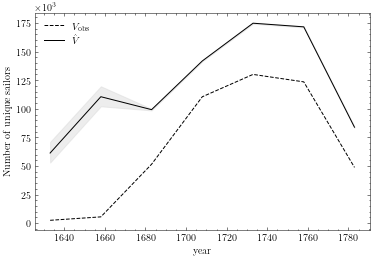

In [57]:
labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, label=r'$V_{\text{obs}}$', color="k", linestyle='dashed')
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates])
ax.plot(labels, est, color="k", label=r'$\hat{V}$')
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique sailors')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend()
plt.savefig('../figures/25year_plot.png', dpi=300)

### Median Sailors

In [59]:
estimates = []
V_observations = []
for index, (start, end) in enumerate(date_ranges):
    print(start, end)
    df_slice = sailors_df[sailors_df['year'].between(start, end, inclusive="left")]
    median_sailors = int(df_slice.groupby(['outward_voyage_id'])['vocop_id'].count().median())
    
    print(f'median number of sailors:{median_sailors}')
    V = DAS_voyages[index] * median_sailors
    records = df_slice.loc[df_slice['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values
    counts = np.array(list(collections.Counter(records).values()))
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)
    q = len(records) / V
    estimate = chao_wor(counts, q)
    estimate['period'] = (start, end)
    estimates.append(estimate)

1633 1658
median number of sailors:148
1658 1683
median number of sailors:262
1683 1708
median number of sailors:204
1708 1733
median number of sailors:199
1733 1758
median number of sailors:254
1758 1783
median number of sailors:312
1783 1795
median number of sailors:298


In [60]:
estimates

[{'q': 0.035675098175098174,
  'f1': 2443,
  'f2': 14,
  'f0': 50411.82422503258,
  'V_obs': 2457,
  'V_est': 52869,
  'var': 11803071.796889361,
  'sd': 3435.559895692311,
  'lci': 46572.40940107014,
  'uci': 60063.90099441612,
  'Chao1': 215522.48866855525,
  'period': (1633, 1658)},
 {'q': 0.035771044472813485,
  'f1': 5432,
  'f2': 30,
  'f0': 112824.08440178585,
  'V_obs': 5462,
  'V_est': 118287,
  'var': 25996296.94366372,
  'sd': 5098.6563861142595,
  'lci': 108727.34775026624,
  'uci': 128729.62363581425,
  'Chao1': 497149.5224083515,
  'period': (1658, 1683)},
 {'q': 0.4416824794433903,
  'f1': 47787,
  'f2': 3190,
  'f0': 51683.57983856962,
  'V_obs': 51501,
  'V_est': 103185,
  'var': 142349.81356994636,
  'sd': 377.2927425354831,
  'lci': 102450.37440348248,
  'uci': 103929.36553351712,
  'Chao1': 409425.2149217709,
  'period': (1683, 1708)},
 {'q': 0.7468052934355033,
  'f1': 95847,
  'f2': 10681,
  'f0': 30212.702328860487,
  'V_obs': 110517,
  'V_est': 140730,
  'var': 

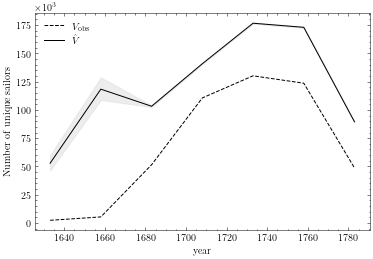

In [61]:
labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, label=r'$V_{\text{obs}}$', color="k", linestyle='dashed')
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates])
ax.plot(labels, est, color="k", label=r'$\hat{V}$')
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique sailors')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend()
plt.savefig('../figures/25year_plot_median.png', dpi=300)

In [104]:
## TODO: make latex table from estimates output